# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [120]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.types import FloatType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.types import TimestampType
from pyspark.sql import Window
from pyspark.sql import functions as F
from pyspark.sql import types as T

from pyspark.ml.feature import Normalizer, StandardScaler, VectorAssembler, MinMaxScaler
from pyspark.ml.classification import DecisionTreeClassifier, GBTClassifier, LogisticRegression, MultilayerPerceptronClassifier, NaiveBayes, RandomForestClassifier
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.tuning import CrossValidatorModel
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml import Pipeline

import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

In [121]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Spark Session") \
    .getOrCreate()

In [122]:
spark.sparkContext.getConf().getAll()

[('spark.driver.host', 'db3621ffa4e4'),
 ('spark.app.id', 'local-1652313979724'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.app.name', 'Spark Session'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.driver.port', '43561'),
 ('spark.ui.showConsoleProgress', 'true')]

In [123]:
spark

# Functions

In [124]:
# Graphs
def plotBar(df, title, xlabel, ylabel):
    """ 
    Bar plot for a given dataframe
    
    Attributes:
        df: pandas dataframe
        title (string): title of the graph
        xlabel (string): x axis label
        ylabel (string): y axis label
            
    """
    ax = df.plot(kind='bar', rot=45, figsize=(12,7))
    ax.set_title(title, fontsize = 20)
    ax.set_xlabel(xlabel, fontsize = 15)
    ax.set_ylabel(ylabel, fontsize = 15)

def plotHist(df, title, xlabel, ylabel):
    """ 
    Histogram plot for a given dataframe.
    
    Attributes:
        df: pandas dataframe
        title (string): title of the graph
        xlabel (string): x axis label
        ylabel (string): y axis label
            
    """
    ax = df.plot.hist(rot=45, figsize=(12,7), alpha=0.5)
    ax.set_title(title, fontsize = 20)
    ax.set_xlabel(xlabel, fontsize = 15)
    ax.set_ylabel(ylabel, fontsize = 15)
    
def plotDensity(df, title, xlabel, ylabel):
    """ 
    Probability density function for a given dataframe.
    
    Attributes:
        df: pandas dataframe
        title (string): title of the graph
        xlabel (string): x axis label
        ylabel (string): y axis label
            
    """
    ax = df.plot.density(rot=45, figsize=(12,7))
    ax.set_title(title, fontsize = 20)
    ax.set_xlabel(xlabel, fontsize = 15)
    ax.set_ylabel(ylabel, fontsize = 15)

In [125]:
# Machine Learning
def classifier_pred(fitted_model, test, label_col = 'churned'):
    """
    Returns dataframe with predictions and labels for fitted model.

    Args:
        fitted_model: fitted model
        test: test set for making predictions
        label_col (string): name of the column for making predictions (default = 'churned')

    Returns: preds_and_labels: Spark Dataframe with predictions and labels
    """
    # Predictions
    predictions = fitted_model.transform(test)
    # Evaluation
    preds_and_labels = predictions.select(['prediction',label_col]).withColumn(label_col, F.col(label_col).cast(FloatType())).orderBy('prediction')
    #select only prediction and label columns
    preds_and_labels = preds_and_labels.select(['prediction',label_col])
    
    return preds_and_labels

def classifier_metrics(preds_and_labels):
    """
    Prints confusion matrix, accuracy, precision, recall and f1-score for the given predictions and labels.

    Args:
        preds_and_labels: Spark Dataframe with predictions and labels

    Returns: None
    """
    
    metrics = MulticlassMetrics(preds_and_labels.rdd.map(tuple))
    
    cm = metrics.confusionMatrix().toArray()
    accuracy = (cm[0][0]+cm[1][1])/cm.sum()
    precision = (cm[1][1])/(cm[1][1]+cm[0][1]) if (cm[1][1]+cm[0][1]) else 0
    recall = (cm[1][1])/(cm[1][1]+cm[1][0]) if (cm[1][1]+cm[1][0]) else 0
    f1score = 2 * ((precision * recall) / (precision + recall)) if (precision + recall) else 0
    
    print("Confusion Matrix:\n", cm, "\n")
    print("Accuracy: " + str(accuracy) + "\n")
    print("Precision: " + str(precision) + "\n")
    print("Recall: " +str(recall) + "\n")
    print("f1-score: " +str(f1score))

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [126]:
path = "mini_sparkify_event_data.json"
user_log = spark.read.json(path)

In [127]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [128]:
user_log.describe()

DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

In [129]:
user_log.show(n=1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
only showi

### Calculate date and hour

In [130]:
# Calculate datetime from timestamp
get_date = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0), TimestampType())

In [131]:
user_log = user_log.withColumn("date", get_date(user_log.ts))

In [132]:
# Calculate hour from timestamp
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)

In [133]:
user_log = user_log.withColumn("hour", get_hour(user_log.ts))

In [134]:
user_log.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', date=datetime.datetime(2018, 10, 1, 0, 1, 57), hour='0')

In [135]:
# songs_in_hour = user_log.filter(user_log.page == "NextSong").groupby(user_log.hour).count().orderBy(user_log.hour.cast("float"))

### Drop rows with missing values

In [136]:
user_log_valid = user_log.dropna(how = "any", subset = ["userId", "sessionId"])

In [137]:
user_log_valid.count()

286500

In [138]:
user_log.select("userId").dropDuplicates().sort("userId").show()

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [139]:
user_log_valid = user_log_valid.filter(user_log_valid["userId"] != "")

In [140]:
user_log_valid.count()

278154

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

## Define Churn

In [141]:
# Here we consider the Cancellation Confirmation as the churn event
flag_churn = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

In [142]:
user_log_valid = user_log_valid.withColumn("churn", flag_churn("page"))

In [143]:
user_log_valid.groupby(['churn']).count().show()

+-----+------+
|churn| count|
+-----+------+
|    1|    52|
|    0|278102|
+-----+------+



In [144]:
churn_users = user_log_valid.filter(F.col('churn')==1).select('userId').collect()
churn_users_list = [i[0] for i in churn_users]

In [145]:
len(churn_users_list)

52

In [146]:
flag_churn_user = udf(lambda x: 1 if x in churn_users_list else 0, IntegerType())

In [147]:
user_log_valid = user_log_valid.withColumn("churned", flag_churn_user("userId"))

## Exploratory analysis

In [148]:
# Here we'll convert to a pandas df for some data analysis
user_log_valid_pd = user_log_valid.toPandas()

In [149]:
user_log_valid_pd.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,sessionId,song,status,ts,userAgent,userId,date,hour,churn,churned
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,...,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 00:01:57,0,0,0
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,...,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,2018-10-01 00:03:00,0,0,0
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,...,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 00:06:34,0,0,0
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,...,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,2018-10-01 00:06:56,0,0,0
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,...,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,2018-10-01 00:11:16,0,0,0


In [150]:
user_log_valid_pd[user_log_valid_pd['churn']==1].shape

(52, 22)

In [151]:
user_log_valid_pd.shape

(278154, 22)

In [152]:
user_log_valid_pd.columns

Index(['artist', 'auth', 'firstName', 'gender', 'itemInSession', 'lastName',
       'length', 'level', 'location', 'method', 'page', 'registration',
       'sessionId', 'song', 'status', 'ts', 'userAgent', 'userId', 'date',
       'hour', 'churn', 'churned'],
      dtype='object')

In [153]:
user_log_valid_pd.page.unique()

array(['NextSong', 'Add to Playlist', 'Roll Advert', 'Thumbs Up',
       'Downgrade', 'Thumbs Down', 'Home', 'Logout', 'Help', 'Upgrade',
       'Add Friend', 'Settings', 'Submit Upgrade', 'About',
       'Submit Downgrade', 'Error', 'Save Settings', 'Cancel',
       'Cancellation Confirmation'], dtype=object)

In [154]:
user_log_valid_pd.auth.unique()

array(['Logged In', 'Cancelled'], dtype=object)

In [155]:
user_log_valid_pd[user_log_valid_pd['userId'].isin(churn_users_list)].userId.nunique()

52

In [156]:
user_log_valid_pd[~user_log_valid_pd['userId'].isin(churn_users_list)].userId.nunique()

173

In [157]:
user_log_valid_pd.userId.nunique()

225

### Number of churned users

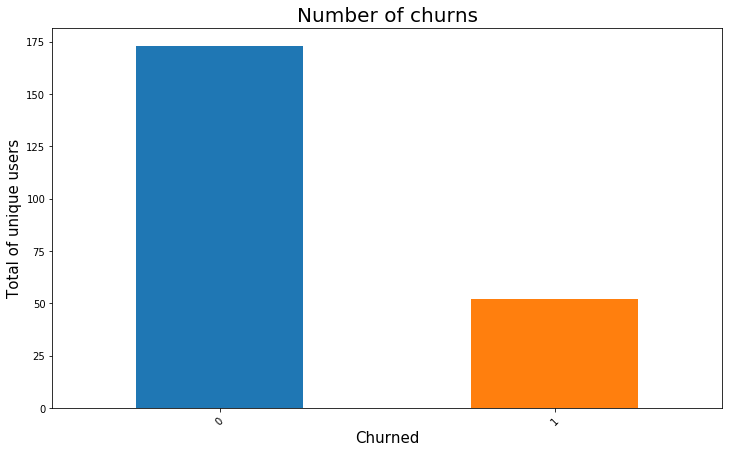

In [39]:
plotBar(user_log_valid_pd.groupby(['churned']).userId.nunique(), 
        'Number of churns', 
        'Churned', 
        'Total of unique users'
       )

About 23.1% of the users have churned

### Gender

In [40]:
users_gender = user_log_valid_pd.groupby(['churned', 'gender']).userId.nunique().reset_index()

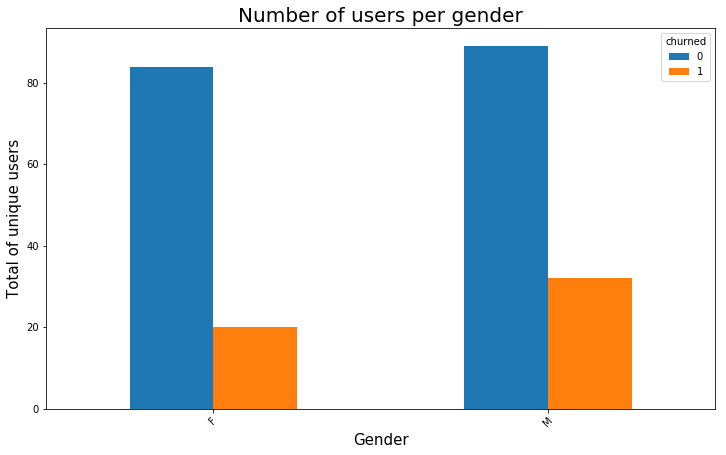

In [41]:
plotBar(users_gender.pivot_table(index='gender', columns='churned', values='userId', aggfunc='sum'), 
        'Number of users per gender', 
        'Gender', 
        'Total of unique users'
       )

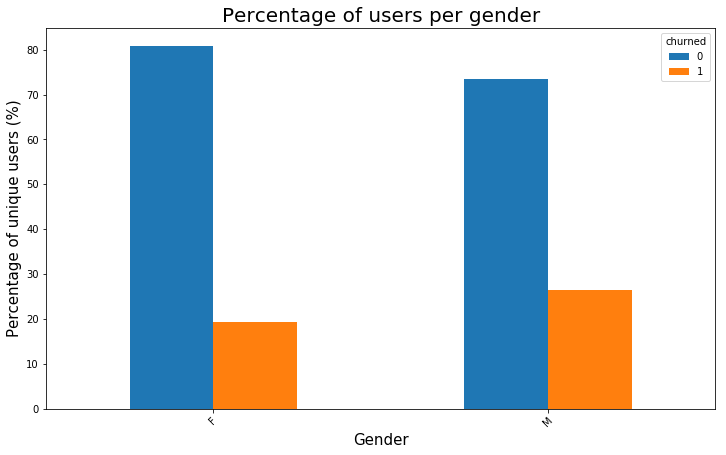

In [42]:
# Plot percentage of each group
tab = users_gender.pivot_table(index='gender', columns='churned', values='userId', aggfunc='sum')
tab = tab.div(tab.sum(axis=1), axis=0) * 100

plotBar(tab, 
        'Percentage of users per gender', 
        'Gender', 
        'Percentage of unique users (%)'
       )

We observed that the churn rate is a little higher among men.

### Payment Level

In [43]:
users_level = user_log_valid_pd.groupby(['churned', 'level']).userId.nunique().reset_index()

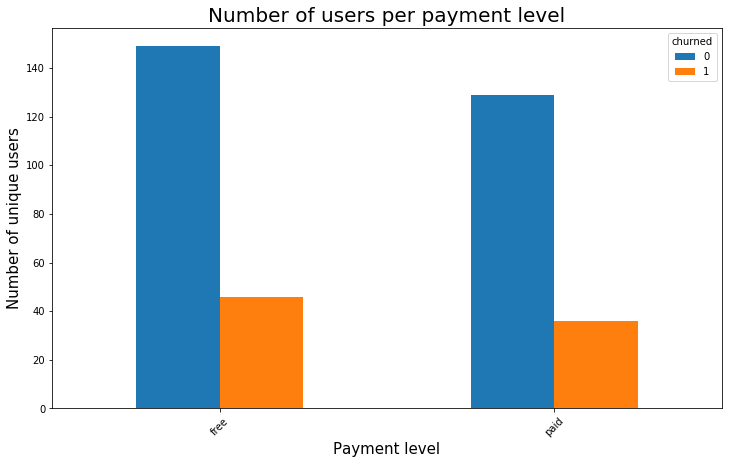

In [44]:
plotBar(users_level.pivot_table(index='level', columns='churned', values='userId', aggfunc='sum'), 
        'Number of users per payment level', 
        'Payment level', 
        'Number of unique users'
       )

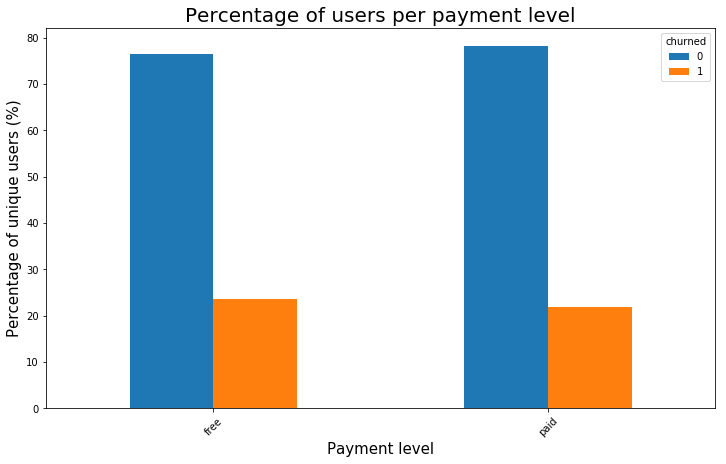

In [45]:
# Plot percentage of each group
tab = users_level.pivot_table(index='level', columns='churned', values='userId', aggfunc='sum')
tab = tab.div(tab.sum(axis=1), axis=0) * 100

plotBar(tab, 
        'Percentage of users per payment level', 
        'Payment level', 
        'Percentage of unique users (%)'
       )

We can observe that the churn rate is almost the same for both groups.

### Frequency of events

In [46]:
users_events = user_log_valid_pd.groupby(['churned', 'page']).userId.nunique().reset_index()

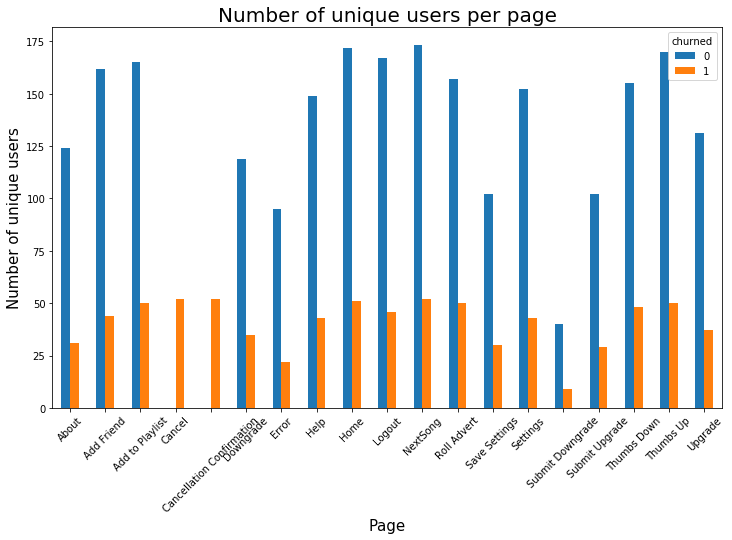

In [47]:
plotBar(users_events.pivot_table(index='page', columns='churned', values='userId', aggfunc='sum'), 
        'Number of unique users per page', 
        'Page', 
        'Number of unique users'
       )

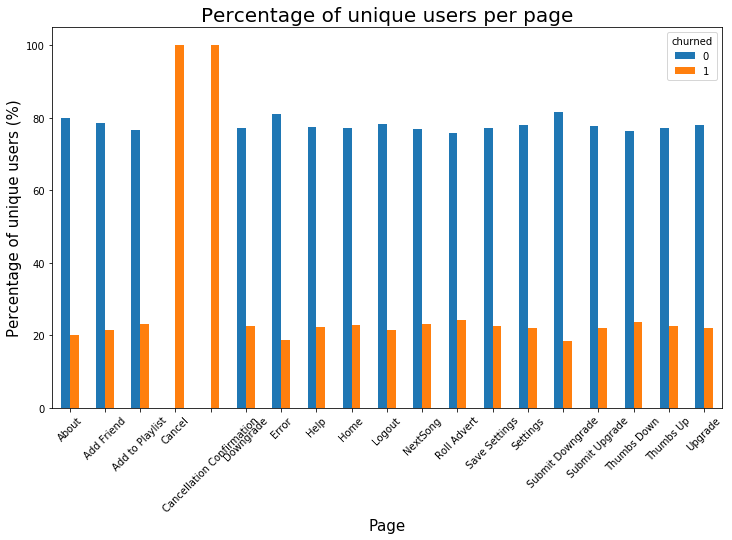

In [48]:
# Plot percentage of each group
tab = users_events.pivot_table(index='page', columns='churned', values='userId', aggfunc='sum')
tab = tab.div(tab.sum(axis=1), axis=0) * 100

plotBar(tab, 
        'Percentage of unique users per page', 
        'Page', 
        'Percentage of unique users (%)'
       )

Some actions did seem to be performed differently when comparing users who churn with users who don't.

### Number of actions within session

In [49]:
users_act = user_log_valid_pd.groupby(['churned', 'userId', 'sessionId']).itemInSession.count().reset_index()

In [50]:
# Here we calculate some descriptive statistics of number of actions within session for each user
users_act = users_act.groupby(['churned', 'userId']).itemInSession.agg(['min', 'max', 'mean', 'median'])

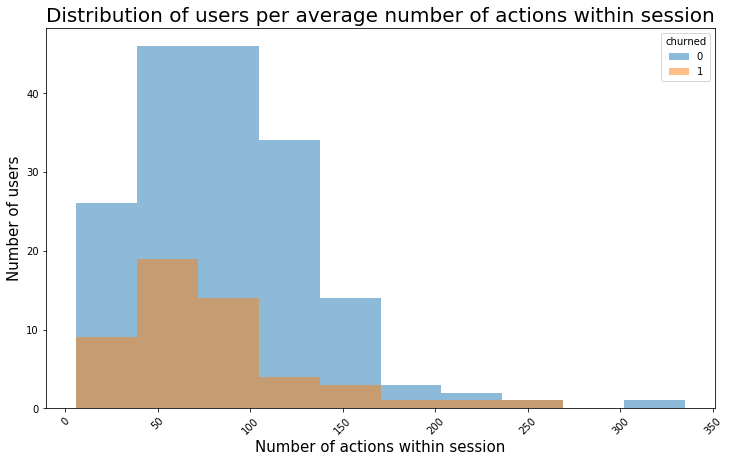

In [51]:
plotHist(users_act.reset_index().pivot_table(index='userId', columns='churned', values='mean', aggfunc='sum'), 
         'Distribution of users per average number of actions within session', 
         'Number of actions within session', 
         'Number of users'
        )

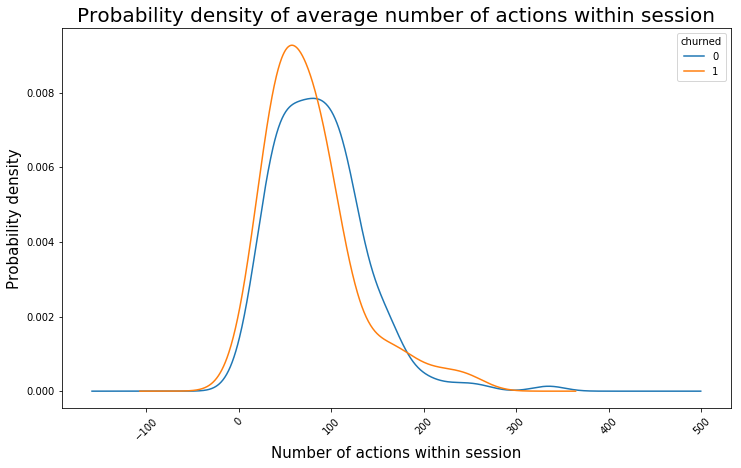

In [52]:
plotDensity(users_act.reset_index().pivot_table(index='userId', columns='churned', values='mean', aggfunc='sum'), 
            'Probability density of average number of actions within session', 
            'Number of actions within session', 
            'Probability density')

Users which churned have performed less actions within a session

### Actions per hour

In [53]:
# calculating session duration, by subtracting the last timestamp within session from the first
session_dur = (user_log_valid_pd.sort_values(by=['churned', 'userId', 'sessionId', 'date'], ascending=True)
               .groupby(['churned', 'userId', 'sessionId']).date.agg(lambda x: x.iat[-1] - x.iat[0])
               .reset_index()
               .rename(columns={'date':'sessionInterval'}))

In [54]:
session_dur.head()

,churned,userId,sessionId,sessionInterval
0,0,10,9,0 days 03:55:52
1,0,10,595,1 days 01:47:55
2,0,10,1047,0 days 01:31:25
3,0,10,1414,0 days 04:15:36
4,0,10,1592,0 days 04:52:03


In [55]:
session_dur.describe()

,churned,sessionId,sessionInterval
count,3176.000000,3176.000000,3176
mean,0.169081,922.456549,0 days 04:59:31.125314
std,0.374882,731.087045,0 days 06:30:16.893295
min,0.000000,1.000000,0 days 00:00:00
25%,0.000000,264.000000,0 days 00:58:07.750000
50%,0.000000,734.500000,0 days 02:40:32.500000
75%,0.000000,1552.250000,0 days 06:21:17
max,1.000000,2474.000000,3 days 02:15:05


In [56]:
# Here we calculate the time diff in hours
session_dur['sessionIntervalHours'] = session_dur['sessionInterval'] / np.timedelta64(1, 'h')

In [57]:
# Merge dataframe with session lenght with count of actions within session
avg_actions = (session_dur
               .merge(user_log_valid_pd.groupby(['churned', 'userId', 'sessionId']).itemInSession.count().reset_index(), 
                      on=['churned', 'userId', 'sessionId'], 
                      how='inner')
              )

In [58]:
# Calculate the average number of action within session
avg_actions['avgActionsHour'] = avg_actions['itemInSession'] / avg_actions['sessionIntervalHours']

In [59]:
avg_actions = avg_actions[avg_actions['sessionIntervalHours']!=0]

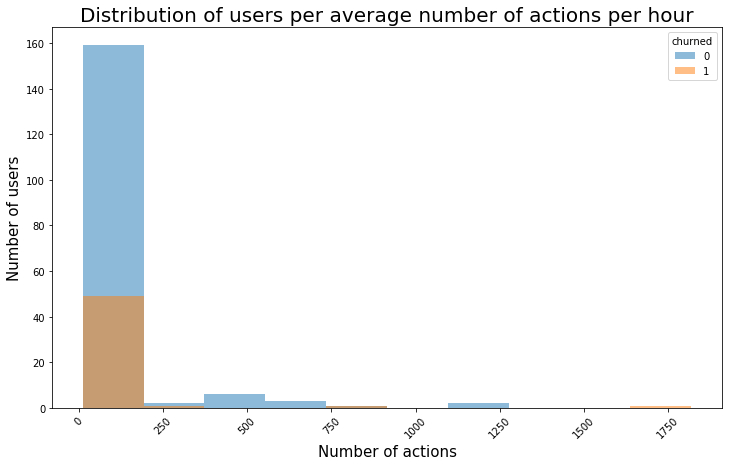

In [60]:
plotHist(avg_actions.pivot_table(index='userId', columns='churned', values='avgActionsHour', aggfunc='mean'), 
         'Distribution of users per average number of actions per hour', 
         'Number of actions', 
         'Number of users'
        )

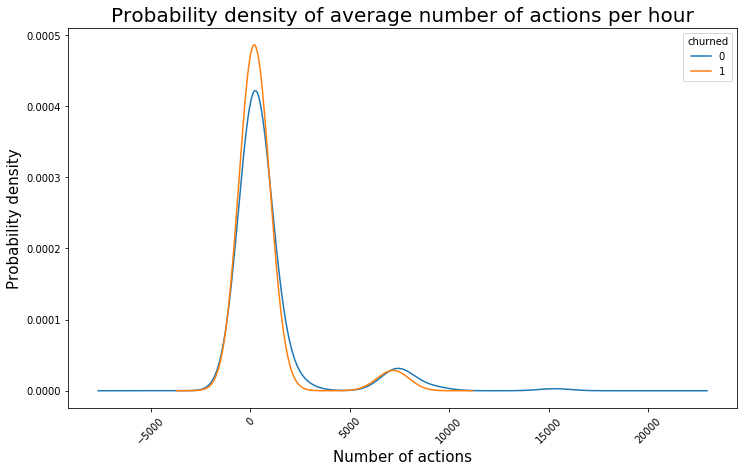

In [61]:
plotDensity(avg_actions.pivot_table(index='userId', columns='churned', values='avgActionsHour', aggfunc='sum'), 
            'Probability density of average number of actions per hour', 
            'Number of actions', 
            'Probability density')

The number of actions per hour seems to have less differeces between the two groups

### Session duration

In [62]:
session_dur.head()

,churned,userId,sessionId,sessionInterval,sessionIntervalHours
0,0,10,9,0 days 03:55:52,3.931111
1,0,10,595,1 days 01:47:55,25.798611
2,0,10,1047,0 days 01:31:25,1.523611
3,0,10,1414,0 days 04:15:36,4.260000
4,0,10,1592,0 days 04:52:03,4.867500


In [63]:
session_dur_df = session_dur.groupby(['churned', 'userId']).sessionIntervalHours.agg(['min', 'max', 'mean', 'median'])

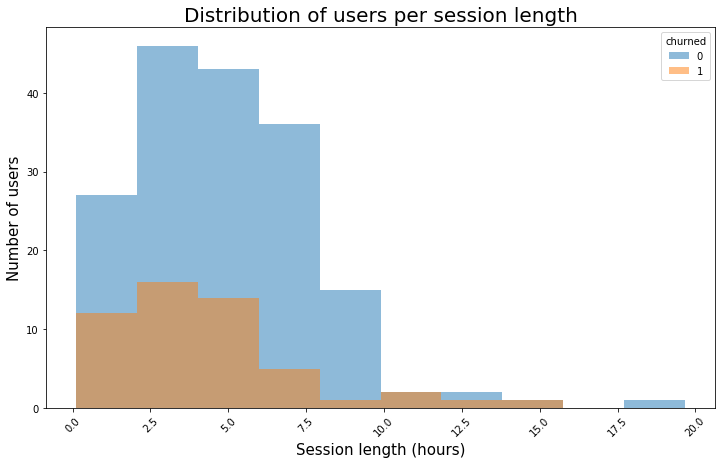

In [64]:
plotHist(session_dur_df.reset_index().pivot_table(index='userId', columns='churned', values='mean', aggfunc='sum'), 
         'Distribution of users per session length', 
         'Session length (hours)', 
         'Number of users'
        )

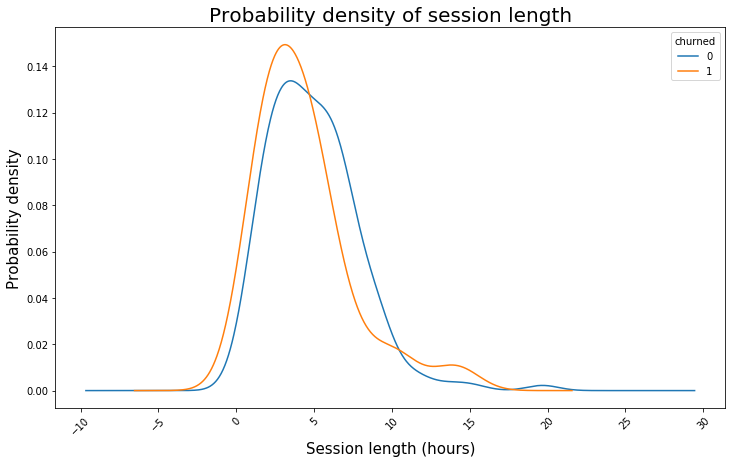

In [65]:
plotDensity(session_dur_df.reset_index().pivot_table(index='userId', columns='churned', values='mean', aggfunc='sum'), 
            'Probability density of session length', 
            'Session length (hours)', 
            'Probability density')

The average duration of the session is longer in the group that did not churn.

### Number of thumbs up

In [66]:
users_tu = (user_log_valid_pd[user_log_valid_pd['page']=='Thumbs Up'].groupby(['churned', 'userId']).ts.count()
            .reset_index()
            .sort_values(by=['churned', 'ts'], ascending=False))

In [67]:
users_tu = users_tu.rename(columns={'ts':'thumbs_up'})

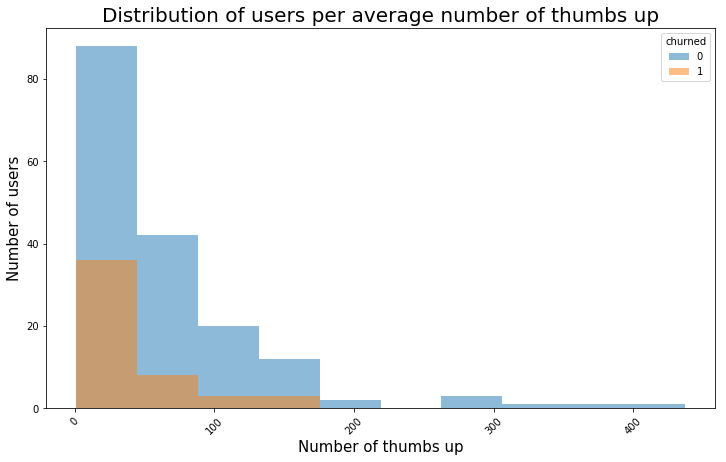

In [68]:
plotHist(users_tu.pivot_table(index='userId', columns='churned', values='thumbs_up', aggfunc='sum'), 
         'Distribution of users per average number of thumbs up', 
         'Number of thumbs up', 
         'Number of users'
        )

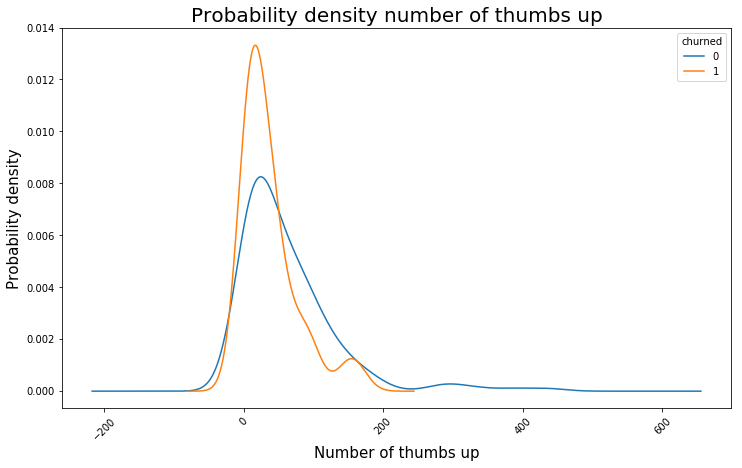

In [69]:
plotDensity(users_tu.pivot_table(index='userId', columns='churned', values='thumbs_up', aggfunc='sum'), 
            'Probability density number of thumbs up', 
            'Number of thumbs up', 
            'Probability density')

Users that churned liked fewer songs than users who didn't.

### Total number of songs played

In [70]:
users_sp = (user_log_valid_pd[user_log_valid_pd['page']=='NextSong'].groupby(['churned', 'userId']).ts.count()
            .reset_index()
            .sort_values(by=['churned', 'ts'], ascending=False))

In [71]:
users_sp = users_sp.rename(columns={'ts':'next_song'})

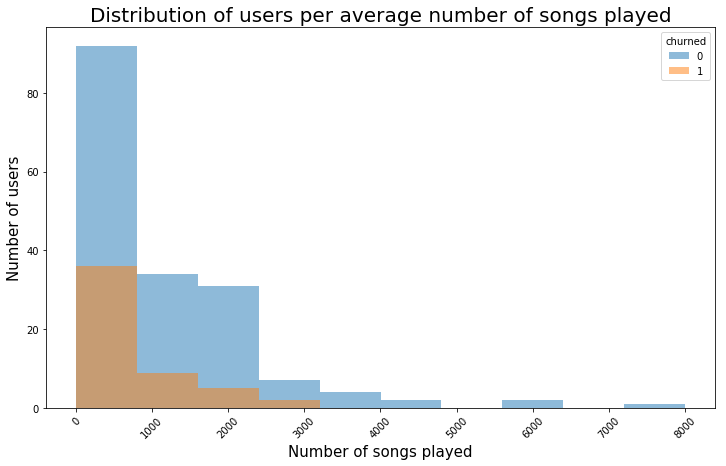

In [72]:
plotHist(users_sp.pivot_table(index='userId', columns='churned', values='next_song', aggfunc='sum'), 
         'Distribution of users per average number of songs played', 
         'Number of songs played', 
         'Number of users'
        )

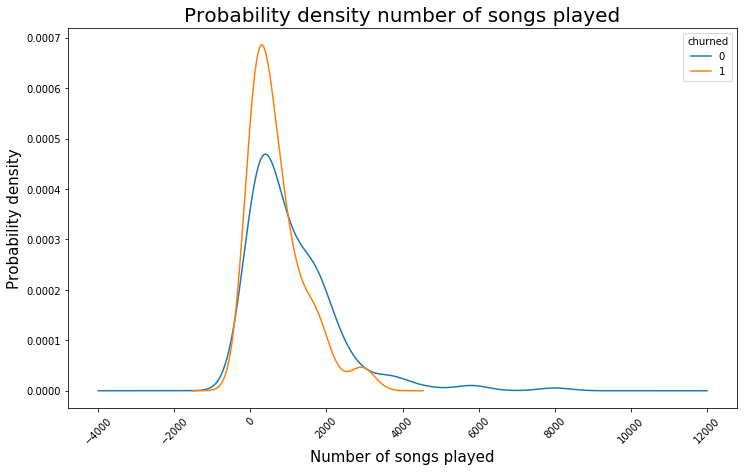

In [73]:
plotDensity(users_sp.pivot_table(index='userId', columns='churned', values='next_song', aggfunc='sum'), 
            'Probability density number of songs played', 
            'Number of songs played', 
            'Probability density')

Users that churned listened to fewer songs than users who didn't.

### Songs played per session

In [74]:
songs_session = user_log_valid_pd[user_log_valid_pd['page']=='NextSong'].groupby(['churned', 'userId', 'sessionId']).itemInSession.count().reset_index()

In [75]:
songs_session = songs_session.groupby(['churned', 'userId']).itemInSession.agg(['min', 'max', 'mean', 'median'])

In [76]:
songs_session.describe()

,min,max,mean,median
count,225.000000,225.000000,225.000000,225.00000
mean,10.866667,230.528889,70.789712,48.36000
std,21.540245,172.547510,42.615370,33.59414
min,1.000000,3.000000,3.000000,3.00000
25%,2.000000,94.000000,38.235294,26.50000
50%,5.000000,201.000000,65.000000,39.50000
75%,11.000000,334.000000,92.000000,60.00000
max,216.000000,1093.000000,286.666667,216.00000


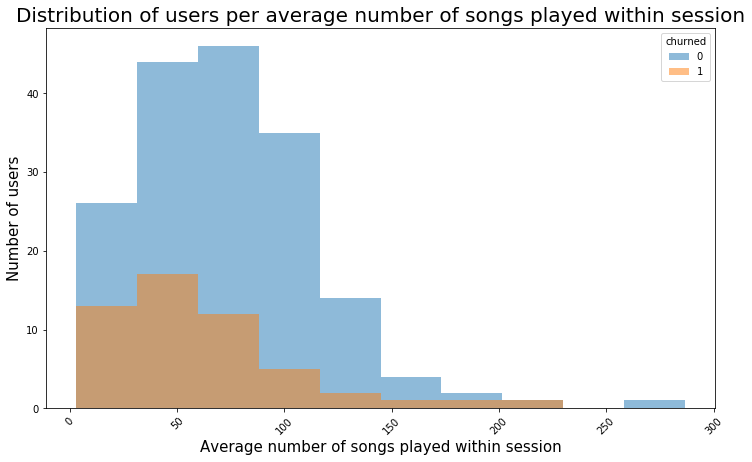

In [77]:
plotHist(songs_session.reset_index().pivot_table(index='userId', columns='churned', values='mean', aggfunc='sum'), 
         'Distribution of users per average number of songs played within session', 
         'Average number of songs played within session', 
         'Number of users'
        )

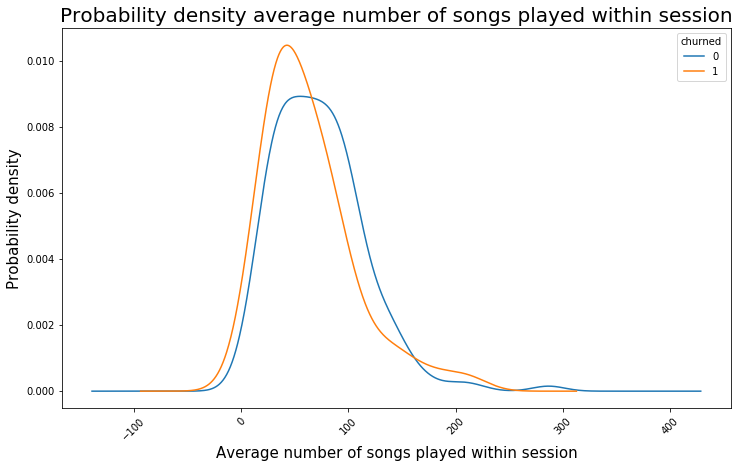

In [78]:
plotDensity(songs_session.reset_index().pivot_table(index='userId', columns='churned', values='mean', aggfunc='sum'), 
            'Probability density average number of songs played within session', 
            'Average number of songs played within session', 
            'Probability density')

Users that churned have played less songs within a session

### Liked songs per session

In [79]:
thumbs_session = user_log_valid_pd[user_log_valid_pd['page']=='Thumbs Up'].groupby(['churned', 'userId', 'sessionId']).itemInSession.count().reset_index()

In [80]:
thumbs_session = thumbs_session.groupby(['churned', 'userId']).itemInSession.agg(['min', 'max', 'mean', 'median'])

In [81]:
thumbs_session.describe()

,min,max,mean,median
count,220.000000,220.000000,220.000000,220.000000
mean,1.363636,13.604545,4.764888,3.527273
std,1.078874,9.973159,2.344118,2.092972
min,1.000000,1.000000,1.000000,1.000000
25%,1.000000,6.000000,3.076560,2.000000
50%,1.000000,12.000000,4.455364,3.000000
75%,1.000000,20.000000,6.000000,4.000000
max,11.000000,51.000000,13.777778,12.500000


Users which churned have played less songs within a session

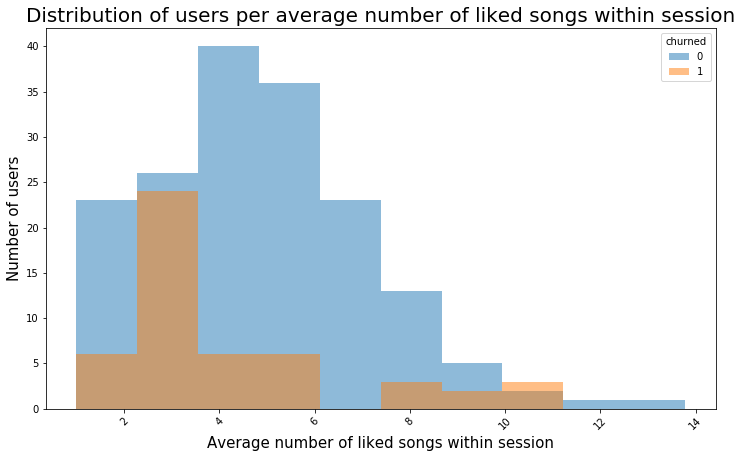

In [82]:
plotHist(thumbs_session.reset_index().pivot_table(index='userId', columns='churned', values='mean', aggfunc='sum'), 
         'Distribution of users per average number of liked songs within session', 
         'Average number of liked songs within session', 
         'Number of users'
        )

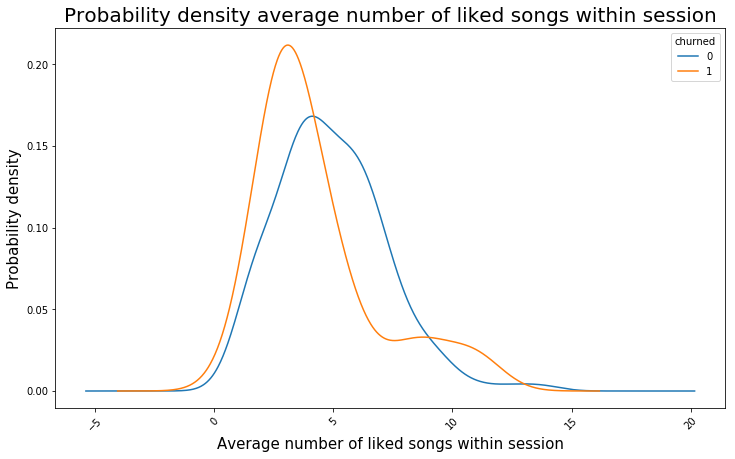

In [83]:
plotDensity(thumbs_session.reset_index().pivot_table(index='userId', columns='churned', values='mean', aggfunc='sum'), 
            'Probability density average number of liked songs within session', 
            'Average number of liked songs within session', 
            'Probability density')

Users that churned have liked less songs within a session.

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [158]:
user_log_valid.show(1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+-------------------+----+-----+-------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|               date|hour|churn|churned|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+-------------------+----+-----+-------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|2018-10-01 00:01:57|   0|    0|      0|
+--------------+---------+---------+------+---------

Here we will calculate several features separately, and then group them into a single dataframe:

### Gender per user

In [159]:
users_genders = user_log_valid.select('churned', 'userId', 'sessionId', 'gender').dropDuplicates()

In [160]:
# Get dummies for gender
users_genders = users_genders.withColumn('gender', F.when(F.col('gender')=='M', 0).when(F.col('gender')=='F', 1))

In [161]:
users_genders.show(5)

+-------+------+---------+------+
|churned|userId|sessionId|gender|
+-------+------+---------+------+
|      0|   133|      167|     0|
|      0|   145|      860|     1|
|      0|    55|     1084|     0|
|      1|100013|      160|     1|
|      1|200015|       15|     0|
+-------+------+---------+------+
only showing top 5 rows



### Number of actions within session

In [162]:
users_sessions = user_log_valid.groupBy('churned', 'userId', 'sessionId').agg(F.count('itemInSession').alias("actions"))

In [163]:
users_sessions.show(5)

+-------+------+---------+-------+
|churned|userId|sessionId|actions|
+-------+------+---------+-------+
|      0|   124|      628|      7|
|      1|   121|      719|     35|
|      0|   128|      895|    166|
|      0|   140|     1056|     59|
|      0|    85|     1183|    125|
+-------+------+---------+-------+
only showing top 5 rows



### Number of pages per user within session

In [164]:
users_pages = user_log_valid.groupby('churned', 'userId', 'sessionId').pivot('page').count().na.fill(0)

In [165]:
# Select valid pages for modeling
page_list = ['churned', 
             'userId', 
             'sessionId', 
             'Thumbs Up',
             'Thumbs Down',
             'NextSong', 
             'Add to Playlist', 
             'Add Friend', 
             'Downgrade', 
             'Upgrade', 
             'About', 
             'Error', 
             'Help', 
             'Home', 
             'Logout', 
             'Roll Advert', 
             'Save Settings', 
             'Settings']
users_pages = users_pages.select([c for c in users_pages.columns if c in page_list])

In [166]:
users_pages = users_pages.select(F.col('churned'), 
                                 F.col('userId'), 
                                 F.col('sessionId'),
                                 F.col('Thumbs Up').alias('thumbsup'), 
                                 F.col('Thumbs Down').alias('thumbsdown'), 
                                 F.col('NextSong').alias('nextsong'), 
                                 F.col('Add to Playlist').alias('addsong'), 
                                 F.col('Add Friend').alias('addfriend'), 
                                 F.col('Downgrade').alias('downgrade'), 
                                 F.col('About').alias('about'),
                                 F.col('Error').alias('error'),
                                 F.col('Help').alias('help'),
                                 F.col('Home').alias('home'),
                                 F.col('Logout').alias('logout'),
                                 F.col('Roll Advert').alias('rolladvert'),
                                 F.col('Save Settings').alias('savesettings'),
                                 F.col('Settings').alias('settings'),
                                 F.col('Upgrade').alias('upgrade'))

In [167]:
users_pages.show(5)

+-------+------+---------+--------+----------+--------+-------+---------+---------+-----+-----+----+----+------+----------+------------+--------+-------+
|churned|userId|sessionId|thumbsup|thumbsdown|nextsong|addsong|addfriend|downgrade|about|error|help|home|logout|rolladvert|savesettings|settings|upgrade|
+-------+------+---------+--------+----------+--------+-------+---------+---------+-----+-----+----+----+------+----------+------------+--------+-------+
|      0|    11|     1350|       0|         0|       6|      0|        0|        0|    1|    0|   0|   1|     1|         1|           0|       0|      0|
|      0|    85|     1183|       4|         0|     105|      3|        0|        1|    0|    0|   1|   6|     1|         2|           0|       1|      0|
|      0|300025|      135|      21|         2|     222|      9|        2|        1|    1|    2|   1|   7|     4|         0|           1|       3|      0|
|      0|300010|      163|       4|         0|      36|      0|        2|   

### Session duration

In [168]:
sessions_dur_max = user_log_valid.groupBy('churned', 'userId', 'sessionId').agg(F.max('date').alias("max_session"))
sessions_dur_min = user_log_valid.groupBy('churned', 'userId', 'sessionId').agg(F.min('date').alias("min_session"))

In [169]:
sessions_dur = sessions_dur_max.join(sessions_dur_min, on=['churned', 'userId', 'sessionId'], how='inner')

In [170]:
# Calculates the time difference in hours
sessions_dur = sessions_dur.withColumn('timediff', (F.col("max_session").cast("long") - F.col("min_session").cast("long"))/3600.)

In [171]:
sessions_dur = sessions_dur.select([c for c in sessions_dur.columns if c in ['churned', 'userId', 'sessionId', 'timediff']])

In [172]:
sessions_dur.show(5)

+-------+------+---------+-----------------+
|churned|userId|sessionId|         timediff|
+-------+------+---------+-----------------+
|      0|100004|      161|           1.8275|
|      0|    11|     1350|           0.3625|
|      0|   124|      628|           0.1625|
|      0|   128|      895|9.140277777777778|
|      0|   140|     1056|3.749722222222222|
+-------+------+---------+-----------------+
only showing top 5 rows



### Merging all dataframes

In [173]:
sdf = (users_genders.join(users_sessions, on=['churned', 'userId', 'sessionId'], how='inner')
       .join(users_pages, on=['churned', 'userId', 'sessionId'], how='inner')
       .join(sessions_dur, on=['churned', 'userId', 'sessionId'], how='inner'))

In [174]:
# Drop any null value
sdf = sdf.dropna(how = "any")

In [175]:
sdf.show(5)

+-------+------+---------+------+-------+--------+----------+--------+-------+---------+---------+-----+-----+----+----+------+----------+------------+--------+-------+-----------------+
|churned|userId|sessionId|gender|actions|thumbsup|thumbsdown|nextsong|addsong|addfriend|downgrade|about|error|help|home|logout|rolladvert|savesettings|settings|upgrade|         timediff|
+-------+------+---------+------+-------+--------+----------+--------+-------+---------+---------+-----+-----+----+----+------+----------+------------+--------+-------+-----------------+
|      0|100004|      161|     1|     26|       1|         0|      19|      0|        0|        0|    0|    0|   0|   3|     2|         1|           0|       0|      0|           1.8275|
|      0|    11|     1350|     1|     10|       0|         0|       6|      0|        0|        0|    1|    0|   0|   1|     1|         1|           0|       0|      0|           0.3625|
|      0|   124|      628|     1|      7|       0|         0|    

In [176]:
# Group by user ID, so we have the information about each user
users_sdf = sdf.groupby('churned', 'userId').agg(F.min('gender').alias('gender'), 
                                                 F.count('sessionId').alias('count_sessions'), 
                                                 F.avg('actions').alias('avg_actions'), 
                                                 F.avg('thumbsup').alias('avg_thumbsup'), 
                                                 F.avg('thumbsdown').alias('avg_thumbsdown'), 
                                                 F.avg('nextsong').alias('avg_nextsong'), 
                                                 F.avg('addsong').alias('avg_addsong'), 
                                                 F.avg('addfriend').alias('avg_addfriend'), 
                                                 F.avg('downgrade').alias('avg_downgrade'),
                                                 F.avg('upgrade').alias('avg_upgrade'), 
                                                 F.avg('about').alias('avg_about'),
                                                 F.avg('error').alias('avg_error'),
                                                 F.avg('help').alias('avg_help'),
                                                 F.avg('home').alias('avg_home'),
                                                 F.avg('logout').alias('avg_logout'),
                                                 F.avg('rolladvert').alias('avg_rolladvert'),
                                                 F.avg('savesettings').alias('avg_savesettings'),
                                                 F.avg('settings').alias('avg_settings'),
                                                 F.avg('timediff').alias('avg_timediff'))

In [177]:
users_sdf.show(5)

+-------+------+------+--------------+------------------+------------------+------------------+-----------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+------------------+------------------+------------------+--------------------+-------------------+-----------------+
|churned|userId|gender|count_sessions|       avg_actions|      avg_thumbsup|    avg_thumbsdown|     avg_nextsong|       avg_addsong|     avg_addfriend|      avg_downgrade|        avg_upgrade|          avg_about|          avg_error|           avg_help|          avg_home|        avg_logout|    avg_rolladvert|    avg_savesettings|       avg_settings|     avg_timediff|
+-------+------+------+--------------+------------------+------------------+------------------+-----------------+------------------+------------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------

In [178]:
users_sdf.printSchema()

root
 |-- churned: integer (nullable = true)
 |-- userId: string (nullable = true)
 |-- gender: integer (nullable = true)
 |-- count_sessions: long (nullable = false)
 |-- avg_actions: double (nullable = true)
 |-- avg_thumbsup: double (nullable = true)
 |-- avg_thumbsdown: double (nullable = true)
 |-- avg_nextsong: double (nullable = true)
 |-- avg_addsong: double (nullable = true)
 |-- avg_addfriend: double (nullable = true)
 |-- avg_downgrade: double (nullable = true)
 |-- avg_upgrade: double (nullable = true)
 |-- avg_about: double (nullable = true)
 |-- avg_error: double (nullable = true)
 |-- avg_help: double (nullable = true)
 |-- avg_home: double (nullable = true)
 |-- avg_logout: double (nullable = true)
 |-- avg_rolladvert: double (nullable = true)
 |-- avg_savesettings: double (nullable = true)
 |-- avg_settings: double (nullable = true)
 |-- avg_timediff: double (nullable = true)



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [104]:
# Define features and labels
X_columns = users_sdf.columns[2:] # Features
y_columns = users_sdf.columns[0] # Label

In [105]:
# Use Vector Assembler to combine features into a single vector column
assembler = VectorAssembler(inputCols=X_columns, outputCol='features')
users_sdf = assembler.transform(users_sdf)

In [106]:
# Split dataset into training and testing data
train, test = users_sdf.randomSplit([0.7, 0.3], seed=10)

In [107]:
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 155
Test Dataset Count: 70


## Iterate through models

Here we are going to test some classification models to compare the results and choose the one we get a better result.

In [108]:
# Creating list of models, with Decision Trees, Naive Bayes, Logistic Regression and Random Forest
models = [DecisionTreeClassifier, NaiveBayes, LogisticRegression, RandomForestClassifier]

In [109]:
# Test which model give us the best metrics
for model in models:
    fitted_model = model(featuresCol = 'features', labelCol = 'churned').fit(train)
    preds_and_labels = classifier_pred(fitted_model, test)
    print("Model: {}".format(model))
    classifier_metrics(preds_and_labels)
    print("\n\n")

Model: <class 'pyspark.ml.classification.DecisionTreeClassifier'>
Confusion Matrix:
 [[ 36.  15.]
 [ 15.   4.]] 

Accuracy: 0.571428571429

Precision: 0.210526315789

Recall: 0.210526315789

f1-score: 0.210526315789



Model: <class 'pyspark.ml.classification.NaiveBayes'>
Confusion Matrix:
 [[ 28.  23.]
 [ 14.   5.]] 

Accuracy: 0.471428571429

Precision: 0.178571428571

Recall: 0.263157894737

f1-score: 0.212765957447



Model: <class 'pyspark.ml.classification.LogisticRegression'>
Confusion Matrix:
 [[ 45.   6.]
 [  7.  12.]] 

Accuracy: 0.814285714286

Precision: 0.666666666667

Recall: 0.631578947368

f1-score: 0.648648648649



Model: <class 'pyspark.ml.classification.RandomForestClassifier'>
Confusion Matrix:
 [[ 42.   9.]
 [ 17.   2.]] 

Accuracy: 0.628571428571

Precision: 0.181818181818

Recall: 0.105263157895

f1-score: 0.133333333333





In [110]:
# Validation with train set
for model in models:
    fitted_model = model(featuresCol = 'features', labelCol = 'churned').fit(train)
    preds_and_labels = classifier_pred(fitted_model, train)
    print("Model: {}".format(model))
    classifier_metrics(preds_and_labels)
    print("\n\n")

Model: <class 'pyspark.ml.classification.DecisionTreeClassifier'>
Confusion Matrix:
 [[ 122.    0.]
 [  14.   19.]] 

Accuracy: 0.909677419355

Precision: 1.0

Recall: 0.575757575758

f1-score: 0.730769230769



Model: <class 'pyspark.ml.classification.NaiveBayes'>
Confusion Matrix:
 [[ 84.  38.]
 [ 13.  20.]] 

Accuracy: 0.670967741935

Precision: 0.344827586207

Recall: 0.606060606061

f1-score: 0.43956043956



Model: <class 'pyspark.ml.classification.LogisticRegression'>
Confusion Matrix:
 [[ 122.    0.]
 [   0.   33.]] 

Accuracy: 1.0

Precision: 1.0

Recall: 1.0

f1-score: 1.0



Model: <class 'pyspark.ml.classification.RandomForestClassifier'>
Confusion Matrix:
 [[ 122.    0.]
 [  10.   23.]] 

Accuracy: 0.935483870968

Precision: 1.0

Recall: 0.69696969697

f1-score: 0.821428571429





We got a higher accuracy and a higher f1 score on Logistic Regression. For this project, it's more important to predict churn, which is the true positive, so we need a higher f1 score, which we got from the Logistic Regression.

### Tuning

Perform cross validation to find better results for the Logistic Regression model:

In [111]:
# Standardizes features by removing the mean and scaling to unit variance
features_scale = StandardScaler(withMean=True, withStd=True, inputCol='features', outputCol='scaled_features')
features_scale_fit = features_scale.fit(users_sdf)
scaled_inputs = features_scale_fit.transform(users_sdf)

In [112]:
scaled_df = scaled_inputs.select(scaled_inputs.churned.alias('label'), scaled_inputs.scaled_features.alias('features'))

In [113]:
# Split scaled dataset into training and testing data
train, test = scaled_df.randomSplit([0.7, 0.3], seed=10)

In [114]:
model = LogisticRegression()
paramGrid = (ParamGridBuilder()
             .addGrid(model.maxIter, [100, 200, 400])
             .addGrid(model.regParam, [0.0, 0.1])
             .addGrid(model.elasticNetParam, [0.0, 0.5, 1])
             .build())

In [115]:
cv = CrossValidator(estimator=model, 
                    estimatorParamMaps=paramGrid,
                    evaluator=MulticlassClassificationEvaluator(),
                    numFolds=3)

In [116]:
cv_fitted = cv.fit(train)

In [117]:
cv_fitted.write().overwrite().save('logistic_regression.model')

In [118]:
cv_fitted = CrossValidatorModel.load('logistic_regression.model') 

In [119]:
preds_and_labels = classifier_pred(cv_fitted, test, label_col = 'label')
classifier_metrics(preds_and_labels)

Confusion Matrix:
 [[ 47.   4.]
 [  8.  11.]] 

Accuracy: 0.828571428571

Precision: 0.733333333333

Recall: 0.578947368421

f1-score: 0.647058823529


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.